In [1]:
import pickle

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.calibration import calibration_curve
from sklearn.metrics import auc
from tensorflow.keras.models import load_model

# stops this program from hogging the GPU
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

CONFIG = {'version':0,
            'thresholds': [7.15], # list of thresholds to be examined.
            'params': ['Date_UTC', 'N', 'E', 'sinMLT', 'cosMLT', 'B_Total', 'BY_GSM',
              'BZ_GSM', 'Vx', 'Vy', 'Vz', 'proton_density', 'T',
               'AE_INDEX', 'SZA', 'dBHt', 'B', 'MLT'],                  # List of parameters that will be used for training.
                                                  # Date_UTC will be removed, kept here for resons that will be evident below
            'test_storm_stime': ['2001-03-29 09:59:00', '2001-08-29 21:59:00', '2005-05-13 21:59:00',
                 '2005-08-30 07:59:00', '2006-12-13 09:59:00', '2010-04-03 21:59:00',
                 '2011-08-04 06:59:00', '2015-03-15 23:59:00'],           # These are the start times for testing storms
            'test_storm_etime': ['2001-04-02 12:00:00', '2001-09-02 00:00:00', '2005-05-17 00:00:00',
                  '2005-09-02 12:00:00', '2006-12-17 00:00:00', '2010-04-07 00:00:00',
                  '2011-08-07 09:00:00', '2015-03-19 14:00:00'],  # end times for testing storms. This will remove them from training
            'plot_titles': ['Mar 2001', 'Sep 2001', 'May 2005', 'Sep 2005', 'Dec 2006', 'Apr 2010', 'Aug 2011', 'Mar 2015'],						# list used for plot titles so I don't have to do it manually
            'forecast': 30,
            'window': 30,																	# time window over which the metrics will be calculated
            'splits': 100,															# amount of k fold splits to be performed. Program will create this many models
            'stations': ['OTT', 'STJ', 'WNG', 'BFE', 'NEW', 'VIC', 'ESK', 'LER'],
            'metrics': ['HSS', 'BIAS', 'STD_PRED', 'RMSE', 'AUC']}
shading_dict = {'0':{'stime':['2001-03-29 10:00:00', '2001-03-30 11:00:00', '2001-03-30 21:00:00', 
                                  '2001-04-01 10:00:00', '2001-03-31 23:30:00', '2001-03-31 20:00:00', 
                                  '2001-04-01 18:00:00'],
                        'etime':['2001-03-29 18:00:00', '2001-03-30 15:00:00', '2001-03-31 04:00:00', 
                                     '2001-04-01 16:00:00', '2001-04-01 06:00:00', '2001-03-31 22:00:00', 
                                     '2001-04-02 04:00:00']},
                '1':{'stime':['2001-08-30 13:00:00', '2001-08-31 06:00:00'],
                        'etime':['2001-08-30 16:00:00', '2001-08-31 10:00:00']},
                '2':{'stime':['2005-05-15 00:30:00', '2005-05-15 16:00:00', '2005-05-16 01:00:00', 
                                  '2005-05-16 06:00:00', '2005-05-16 12:00:00'],
                        'etime':['2005-05-15 06:00:00', '2005-05-15 21:00:00', '2005-05-16 05:00:00', 
                                     '2005-05-16 10:00:00', '2005-05-16 17:00:00']},
                '3':{'stime':['2005-08-30 17:00:00', '2005-08-31 12:00:00', '2005-09-01 00:00:00', 
                                  '2005-09-02 04:00:00'],
                        'etime':['2005-08-30 19:00:00', '2005-08-31 16:00:00', '2005-09-01 04:00:00', 
                                     '2005-09-02 11:00:00']},
                '4':{'stime':['2006-12-13 11:00:00', '2006-12-14 12:30:00', '2006-12-15 04:00:00', 
                                  '2006-12-15 16:00:00', '2006-12-16 03:30:00', '2006-12-16 16:30:00'],
                        'etime':['2006-12-13 19:00:00', '2006-12-14 22:00:00', '2006-12-15 13:00:00', 
                                     '2006-12-15 21:00:00', '2006-12-16 09:00:00', '2006-12-16 22:00:00']},
                '5':{'stime':['2010-04-04 04:00:00', '2010-04-04 14:00:00', '2010-04-05 09:30:00', 
                                  '2010-04-05 18:00:00', '2010-04-06 13:00:00'],
                        'etime':['2010-04-04 09:00:00', '2010-04-05 00:00:00', '2010-04-05 12:00:00', 
                                     '2010-04-06 01:00:00', '2010-04-06 23:00:00']},
                '6':{'stime':['2011-08-04 20:30:00', '2011-08-05 17:00:00', '2011-08-05 22:00:00', 
                                  '2011-08-06 03:00:00'],
                        'etime':['2011-08-05 01:30:00', '2011-08-05 19:00:00', '2011-08-06 00:30:00', 
                                     '2011-08-06 05:30:00']},
                '7':{'stime':['2015-03-16 04:00:00', '2015-03-16 12:00:00', '2015-03-17 03:00:00', 
                                  '2015-03-17 06:30:00', '2015-03-17 18:00:00', '2015-03-18 00:00:00', 
                                  '2015-03-19 00:00:00'],
                        'etime':['2015-03-16 07:00:00', '2015-03-16 18:00:00', '2015-03-17 05:00:00', 
                                     '2015-03-17 12:30:00', '2015-03-17 20:00:00', '2015-03-18 14:00:00', 
                                     '2015-03-19 10:00:00']}}

2022-11-15 10:50:01.543830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 10:50:01.548557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 10:50:01.548671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
def load_stats():

    with open('outputs/stations_results_dict.pkl', 'rb') as f:
        stations_dict = pickle.load(f)

    return stations_dict

In [3]:
def loading_input_data():

    '''Preparing the omnidata for plotting.
        Inputs:
        path: path to project directory
    '''
    input_data = {}
    for station in CONFIG['stations']:
        df = pd.read_feather('../data/ace_and_supermag/{0}_prepared.feather'.format(station))     # loading the omni data

        df.reset_index(drop=True, inplace=True)        # reseting the index so its easier to work with integer indexes
        
        df['MLT'] = np.sqrt(((np.arccos(df['cosMLT']))*(360/(2*np.pi*15))**2)+((np.arcsin(df['sinMLT']))*(360/(2*np.pi*15))**2))
        
        # reassign the datetime object as the index
        pd.to_datetime(df['Date_UTC'], format='%Y-%m-%d %H:%M:%S')
        df.set_index('Date_UTC', inplace=True, drop=True)
        df.index = pd.to_datetime(df.index)
        input_data[station] = df

    return input_data

In [31]:
results_dict = load_stats()
input_data = loading_input_data()


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(uf

In [53]:
print(input_data['OTT']['dBHt'][:35])
# print(input_data['OTT']['dBHt'].shift(-30)[:35])
# indexer = pd.core.window.rolling.Rolling.max(window_size=30)
print(input_data['OTT']['dBHt'].rolling(30, min_periods=1).max()[1175:1195])

Date_UTC
1995-01-01 00:01:00    0.000000
1995-01-01 00:02:00    0.100000
1995-01-01 00:03:00    0.000000
1995-01-01 00:04:00    0.100000
1995-01-01 00:05:00    0.000000
1995-01-01 00:06:00    1.019804
1995-01-01 00:07:00    1.389244
1995-01-01 00:08:00    0.000000
1995-01-01 00:09:00    0.000000
1995-01-01 00:10:00    0.100000
1995-01-01 00:11:00    1.044031
1995-01-01 00:12:00    0.100000
1995-01-01 00:13:00    1.044031
1995-01-01 00:14:00    0.000000
1995-01-01 00:15:00    0.141421
1995-01-01 00:16:00    0.000000
1995-01-01 00:17:00    0.000000
1995-01-01 00:18:00    0.000000
1995-01-01 00:19:00    1.389244
1995-01-01 00:20:00    1.019804
1995-01-01 00:21:00    0.000000
1995-01-01 00:22:00    0.100000
1995-01-01 00:23:00    1.044031
1995-01-01 00:24:00    1.019804
1995-01-01 00:25:00    0.000000
1995-01-01 00:26:00    0.100000
1995-01-01 00:27:00    0.000000
1995-01-01 00:28:00    0.000000
1995-01-01 00:29:00    1.044031
1995-01-01 00:30:00    0.000000
1995-01-01 00:31:00    0.948683

In [5]:
def prep_k_fold_results(df, splits):
    '''prepares the data from the k-folds for plotting and examination. Creates a dataframe that stores the upper and lower calculated bounds for the plotting.
        Inputs:
        df: dataframe from a particular storm that is being examined. Includes the real data and the predicted data for each split model.
        threshold: threshold that is being examined.
        splits: integer number of split models that have been trained. Used here for indexing.
        stime: datetime string that defines the start time for the plotting.
        etime: datetime string that defines the end time for the plotting.'''

    newdf = pd.DataFrame()				# initalizes the new dataframe
    for split in range(splits):			# looping through the splits
        newdf['split_{0}'.format(split)] = df['predicted_split_{0}'.format(split)]		# grabs the predicted data for the threshold examined and puts them in the newdf
    mean = newdf.mean(axis=1)
    top_perc = newdf.quantile(0.975, axis=1)
    bottom_perc = newdf.quantile(0.025, axis=1)
    newdf['cross'] = df['crossing']
    newdf['mean'] = mean			# calculated the mean for each row and creates a new collumn
    newdf['top_perc'] = top_perc	# creates a new column and populates it with the 97.5th percentile data from each row
    newdf['bottom_perc'] = bottom_perc		# creates a new column and populates it with the 2.5th percentile data from each row
    newdf['date'] = df.index							# establishes a date column that will be used as the index

    # establishes the datetime index from the date column
    pd.to_datetime(newdf['date'], format='%Y-%m-%d %H:%M:%S')
    newdf.reset_index(drop=True, inplace=True)
    newdf.set_index('date', inplace=True, drop=True)
    newdf.index = pd.to_datetime(newdf.index)

    return newdf


In [6]:
def plot_model_outputs(results_dict, storm, shade_stime, shade_etime, splits, title, stime, etime):
    '''plots all of the model output results with confidence intervals.
        Inputs:
        df: dataframe for a particular storm
        stime: datetime string for starting time of the plot.
        etime: datetime string for ending time of the plot.
        splits: integer number of splits used for model training
    '''

    # calling the prep_k_fold function for each threshold. Should probably find a better way to do this.
    OTT = prep_k_fold_results(results_dict['OTT']['storm_{0}'.format(storm)]['raw_results'], splits)
    BFE = prep_k_fold_results(results_dict['BFE']['storm_{0}'.format(storm)]['raw_results'], splits)
    WNG = prep_k_fold_results(results_dict['WNG']['storm_{0}'.format(storm)]['raw_results'], splits)
    STJ = prep_k_fold_results(results_dict['STJ']['storm_{0}'.format(storm)]['raw_results'], splits)
    NEW = prep_k_fold_results(results_dict['NEW']['storm_{0}'.format(storm)]['raw_results'], splits)
    VIC = prep_k_fold_results(results_dict['VIC']['storm_{0}'.format(storm)]['raw_results'], splits)
    ESK = prep_k_fold_results(results_dict['ESK']['storm_{0}'.format(storm)]['raw_results'], splits)
    LER = prep_k_fold_results(results_dict['LER']['storm_{0}'.format(storm)]['raw_results'], splits)


    # this creats a new dataframe that will allow me to create a bar at the top of the plot to define the periods where the real, binary values have value 1.
    OTT_bar = pd.DataFrame({'OTT_bottom':OTT['cross']*1.01,
                            'OTT_top':OTT['cross']*1.06},
                            index=OTT.index)
    BFE_bar = pd.DataFrame({'BFE_bottom':BFE['cross']*1.01,
                            'BFE_top':BFE['cross']*1.06},
                            index=BFE.index)
    WNG_bar = pd.DataFrame({'WNG_bottom':WNG['cross']*1.01,
                            'WNG_top':WNG['cross']*1.06},
                            index=WNG.index)
    STJ_bar = pd.DataFrame({'STJ_bottom':STJ['cross']*1.01,
                            'STJ_top':STJ['cross']*1.06},
                            index=STJ.index)
    NEW_bar = pd.DataFrame({'NEW_bottom':NEW['cross']*1.01,
                            'NEW_top':NEW['cross']*1.06},
                            index=NEW.index)
    VIC_bar = pd.DataFrame({'VIC_bottom':VIC['cross']*1.01,
                            'VIC_top':VIC['cross']*1.06},
                            index=VIC.index)
    ESK_bar = pd.DataFrame({'ESK_bottom':ESK['cross']*1.01,
                            'ESK_top':ESK['cross']*1.06},
                            index=ESK.index)
    LER_bar = pd.DataFrame({'LER_bottom':LER['cross']*1.01,
                            'LER_top':LER['cross']*1.06},
                            index=LER.index)

    OTT_bar.index=pd.to_datetime(OTT_bar.index)					# adds datetime index
    BFE_bar.index=pd.to_datetime(BFE_bar.index)					# adds datetime index
    WNG_bar.index=pd.to_datetime(WNG_bar.index)					# adds datetime index
    STJ_bar.index=pd.to_datetime(STJ_bar.index)					# adds datetime index
    NEW_bar.index=pd.to_datetime(NEW_bar.index)					# adds datetime index
    VIC_bar.index=pd.to_datetime(VIC_bar.index)					# adds datetime index
    ESK_bar.index=pd.to_datetime(ESK_bar.index)					# adds datetime index
    LER_bar.index=pd.to_datetime(LER_bar.index)					# adds datetime index
    
    
    fig = plt.figure(figsize=(60,55))				# establishing the larger plot
    plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, hspace=0.03)		# triming the whitespace in between the subplots
    plt.title(title, fontsize=130)

    ax1 = fig.add_subplot(811)			# initalizing the subplot
    z1=np.array(BFE_bar['BFE_bottom'])		# creates an array from the y_bar dataframe
    z2=np.array(BFE_bar['BFE_top'])			# creates another array. These two arrays are compared to create the bar at the top of the plots.
    ax1.plot(BFE['mean'])								# plots the mean columns of the dataframe.
    ax1.fill_between(BFE.index, BFE['bottom_perc'], BFE['top_perc'], alpha=0.2)	# type: ignore # fills the area between the confidence interval with a lighter shade
    for s, e in zip(shade_stime, shade_etime):
        ax1.fill_between(BFE[s:e].index, 0, 1, alpha=0.2, color='g')
    ax1.fill_between(BFE_bar.index, BFE_bar['BFE_bottom'], BFE_bar['BFE_top'], where=z2>z1, alpha=1)												# type: ignore # creates a bar at the top of the plot indicating the positve part of the binary real data
    ax1.margins(x=0)							# tightning the plot margins
    ax1.set_ylabel('BFE', fontsize='45')
    plt.yticks(fontsize='45')
    ax1.set_xticklabels('')

    ax2 = fig.add_subplot(812, sharex=ax1)
    z1=np.array(WNG_bar['WNG_bottom'])
    z2=np.array(WNG_bar['WNG_top'])
    ax2.plot(WNG.index, WNG['mean'])
    ax2.fill_between(WNG.index, WNG['bottom_perc'], WNG['top_perc'], alpha=0.2)  # type: ignore
    for s, e in zip(shade_stime, shade_etime):
        ax2.fill_between(WNG[s:e].index, 0, 1, alpha=0.2, color='g')
    ax2.fill_between(WNG_bar.index, WNG_bar['WNG_bottom'], WNG_bar['WNG_top'], where=z2>z1, alpha=1)  # type: ignore
    ax2.margins(x=0)
    ax2.set_ylabel('WNG', fontsize='45')
    plt.yticks(fontsize='45')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n %H:%M'))			# adds the date to the bottom of the plot

    ax3 = fig.add_subplot(813, sharex=ax1)			# initalizing the subplot
    z1=np.array(LER_bar['LER_bottom'])		# creates an array from the y_bar dataframe
    z2=np.array(LER_bar['LER_top'])			# creates another array. These two arrays are compared to create the bar at the top of the plots.
    ax3.plot(LER['mean'])								# plots the mean columns of the dataframe.
    ax3.fill_between(LER.index, LER['bottom_perc'], LER['top_perc'], alpha=0.2)	# type: ignore # fills the area between the confidence interval with a lighter shade
    for s, e in zip(shade_stime, shade_etime):
        ax3.fill_between(LER[s:e].index, 0, 1, alpha=0.2, color='g')
    ax3.fill_between(LER_bar.index, LER_bar['LER_bottom'], LER_bar['LER_top'], where=z2>z1, alpha=1)												# type: ignore # creates a bar at the top of the plot indicating the positve part of the binary real data
    ax3.margins(x=0)							# tightning the plot margins
    ax3.set_ylabel('LER', fontsize='45')
    plt.yticks(fontsize='45')
    ax3.set_xticklabels('')

    ax4 = fig.add_subplot(814, sharex=ax1)
    z1=np.array(ESK_bar['ESK_bottom'])
    z2=np.array(ESK_bar['ESK_top'])
    ax4.plot(ESK.index, ESK['mean'])
    ax4.fill_between(ESK.index, ESK['bottom_perc'], ESK['top_perc'], alpha=0.2)  # type: ignore
    for s, e in zip(shade_stime, shade_etime):
        ax4.fill_between(ESK[s:e].index, 0, 1, alpha=0.2, color='g')
    ax4.fill_between(ESK_bar.index, ESK_bar['ESK_bottom'], ESK_bar['ESK_top'], where=z2>z1, alpha=1)  # type: ignore
    ax4.margins(x=0)
    ax4.set_ylabel('ESK', fontsize='45')
    plt.yticks(fontsize='45')
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n %H:%M'))			# adds the date to the bottom of the plot

    ax5 = fig.add_subplot(815, sharex=ax1)			# initalizing the subplot
    z1=np.array(STJ_bar['STJ_bottom'])		# creates an array from the y_bar dataframe
    z2=np.array(STJ_bar['STJ_top'])			# creates another array. These two arrays are compared to create the bar at the top of the plots.
    ax5.plot(STJ['mean'])								# plots the mean columns of the dataframe.
    ax5.fill_between(STJ.index, STJ['bottom_perc'], STJ['top_perc'], alpha=0.2)	# type: ignore # fills the area between the confidence interval with a lighter shade
    for s, e in zip(shade_stime, shade_etime):
        ax5.fill_between(STJ[s:e].index, 0, 1, alpha=0.2, color='g')
    ax5.fill_between(STJ_bar.index, STJ_bar['STJ_bottom'], STJ_bar['STJ_top'], where=z2>z1, alpha=1)												# type: ignore # creates a bar at the top of the plot indicating the positve part of the binary real data
    ax5.margins(x=0)							# tightning the plot margins
    ax5.set_ylabel('STJ', fontsize='45')
    plt.yticks(fontsize='45')
    ax5.set_xticklabels('')

    ax6 = fig.add_subplot(816, sharex=ax1)
    z1=np.array(OTT_bar['OTT_bottom'])
    z2=np.array(OTT_bar['OTT_top'])
    ax6.plot(OTT['mean'])
    ax6.fill_between(OTT.index, OTT['bottom_perc'], OTT['top_perc'], alpha=0.2)  # type: ignore
    for s, e in zip(shade_stime, shade_etime):
        ax6.fill_between(OTT[s:e].index, 0, 1, alpha=0.2, color='g')
    ax6.fill_between(OTT_bar.index, OTT_bar['OTT_bottom'], OTT_bar['OTT_top'], where=z2>z1, alpha=1)  # type: ignore
    ax6.margins(x=0)
    ax6.set_ylabel('OTT', fontsize='45')
    plt.yticks(fontsize='45')
    plt.xticks(fontsize=30)
    ax6.set_xticklabels('')

    ax7 = fig.add_subplot(817, sharex=ax1)
    z1=np.array(NEW_bar['NEW_bottom'])
    z2=np.array(NEW_bar['NEW_top'])
    ax7.plot(NEW['mean'])
    ax7.fill_between(NEW.index, NEW['bottom_perc'], NEW['top_perc'], alpha=0.2)  # type: ignore
    for s, e in zip(shade_stime, shade_etime):
        ax7.fill_between(NEW[s:e].index, 0, 1, alpha=0.2, color='g')
    ax7.fill_between(NEW_bar.index, NEW_bar['NEW_bottom'], NEW_bar['NEW_top'], where=z2>z1, alpha=1)  # type: ignore
    ax7.margins(x=0)
    ax7.set_ylabel('NEW', fontsize='45')
    plt.yticks(fontsize='45')
    plt.xticks(fontsize=30)
    ax7.set_xticklabels('')

    ax8 = fig.add_subplot(818, sharex=ax1)
    z1=np.array(VIC_bar['VIC_bottom'])
    z2=np.array(VIC_bar['VIC_top'])
    ax8.plot(VIC['mean'])
    ax8.fill_between(VIC.index, VIC['bottom_perc'], VIC['top_perc'], alpha=0.2)  # type: ignore
    for s, e in zip(shade_stime, shade_etime):
        ax8.fill_between(VIC[s:e].index, 0, 1, alpha=0.2, color='g')
    ax8.fill_between(VIC_bar.index, VIC_bar['VIC_bottom'], VIC_bar['VIC_top'], where=z2>z1, alpha=1)  # type: ignore
    ax8.margins(x=0)
    ax8.set_ylabel('VIC', fontsize='45')
    plt.yticks(fontsize='45')
    plt.xticks(fontsize=30)
    ax8.xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n %H:%M'))			# adds the date to the bottom of the plot
    plt.savefig('plots/presentation_storm.png')

In [7]:
input_data['OTT'].columns

Index(['N', 'E', 'sinMLT', 'cosMLT', 'B_Total', 'BY_GSM', 'BZ_GSM', 'Vx', 'Vy',
       'Vz', 'proton_density', 'T', 'AE_INDEX', 'SZA', 'dBHt', 'B', 'crossing',
       'MLT'],
      dtype='object')

In [8]:
def plot_model_SW_inputs(input_data, shade_stime, shade_etime, title, stime, etime):
    '''plots all of the model output results with confidence intervals.
        Inputs:
        df: dataframe for a particular storm
        stime: datetime string for starting time of the plot.
        etime: datetime string for ending time of the plot.
        splits: integer number of splits used for model training
    '''
    df = input_data['OTT'][stime:etime]
    
    fig = plt.figure(figsize=(60,55))				# establishing the larger plot
    plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, hspace=0.03)		# triming the whitespace in between the subplots
    plt.title('{0} SW Inputs'.format(title), fontsize=130)

    ax1 = fig.add_subplot(811)			# initalizing the subplot
    ax1.plot(df['B_Total'])								# plots the mean columns of the dataframe.
    for s, e in zip(shade_stime, shade_etime):
        ax1.fill_between(df[s:e].index, df['B_Total'].min(), df['B_Total'].max(), alpha=0.2, color='g')
    ax1.margins(x=0)							# tightning the plot margins
    ax1.set_ylabel('B_Total', fontsize='45')
    plt.yticks(fontsize='45')
    ax1.set_xticklabels('')

    ax2 = fig.add_subplot(812, sharex=ax1)
    ax2.plot(df['BY_GSM'])
    for s, e in zip(shade_stime, shade_etime):
        ax2.fill_between(df[s:e].index, df['BY_GSM'].min(), df['BY_GSM'].max(), alpha=0.2, color='g')
    ax2.margins(x=0)
    ax2.set_ylabel('By', fontsize='45')
    plt.yticks(fontsize='45')
    ax2.set_xticklabels('')

    ax3 = fig.add_subplot(813, sharex=ax1)			# initalizing the subplot
    ax3.plot(df['BZ_GSM'])								# plots the mean columns of the dataframe.
    for s, e in zip(shade_stime, shade_etime):
        ax3.fill_between(df[s:e].index, df['BZ_GSM'].min(), df['BZ_GSM'].max(), alpha=0.2, color='g')
    ax3.margins(x=0)							# tightning the plot margins
    ax3.set_ylabel('Bz', fontsize='45')
    plt.yticks(fontsize='45')
    ax3.set_xticklabels('')

    ax4 = fig.add_subplot(814, sharex=ax1)
    ax4.plot(df['Vx'])
    for s, e in zip(shade_stime, shade_etime):
        ax4.fill_between(df[s:e].index, df['Vx'].min(), df['Vx'].max(), alpha=0.2, color='g')
    ax4.margins(x=0)
    ax4.set_ylabel('Vx', fontsize='45')
    plt.yticks(fontsize='45')
    ax4.set_xticklabels('')

    ax5 = fig.add_subplot(815, sharex=ax1)			# initalizing the subplot
    ax5.plot(df['Vy'])								# plots the mean columns of the dataframe.
    for s, e in zip(shade_stime, shade_etime):
        ax5.fill_between(df[s:e].index, df['Vy'].min(), df['Vy'].max(), alpha=0.2, color='g')
    ax5.margins(x=0)							# tightning the plot margins
    ax5.set_ylabel('Vy', fontsize='45')
    plt.yticks(fontsize='45')
    ax5.set_xticklabels('')

    ax6 = fig.add_subplot(816, sharex=ax1)
    ax6.plot(df['proton_density'])
    for s, e in zip(shade_stime, shade_etime):
        ax6.fill_between(df[s:e].index, df['proton_density'].min(), df['proton_density'].max(), alpha=0.2, color='g')
    ax6.margins(x=0)
    ax6.set_ylabel(r'$\rho$', fontsize='45')
    plt.yticks(fontsize='45')
    ax6.set_xticklabels('')

    ax7 = fig.add_subplot(817, sharex=ax1)
    ax7.plot(df['T'])
    for s, e in zip(shade_stime, shade_etime):
        ax7.fill_between(df[s:e].index, df['T'].min(), df['T'].max(), alpha=0.2, color='g')
    ax7.margins(x=0)
    ax7.set_ylabel('T', fontsize='45')
    plt.yticks(fontsize='45')
    ax7.set_xticklabels('')

    ax8 = fig.add_subplot(818, sharex=ax1)
    ax8.plot(df['AE_INDEX'])
    for s, e in zip(shade_stime, shade_etime):
        ax8.fill_between(df[s:e].index, df['AE_INDEX'].min(), df['AE_INDEX'].max(), alpha=0.2, color='g')
    ax8.margins(x=0)
    ax8.set_ylabel('AE', fontsize='45')
    plt.yticks(fontsize='45')
    plt.xticks(fontsize=30)
    ax8.xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n %H:%M'))			# adds the date to the bottom of the plot
    plt.savefig('plots/presentation_SW.png')

In [9]:
def plot_model_dbht_inputs(input_data, shade_stime, shade_etime, title, stime, etime):
    '''plots all of the model output results with confidence intervals.
        Inputs:
        df: dataframe for a particular storm
        stime: datetime string for starting time of the plot.
        etime: datetime string for ending time of the plot.
        splits: integer number of splits used for model training
    '''
    maxes = []
    BFE = input_data['BFE'][stime:etime]
    WNG = input_data['WNG'][stime:etime]
    LER = input_data['LER'][stime:etime]
    ESK = input_data['ESK'][stime:etime]
    STJ = input_data['STJ'][stime:etime]
    OTT = input_data['OTT'][stime:etime]
    NEW = input_data['NEW'][stime:etime]
    VIC = input_data['VIC'][stime:etime]
    for station in input_data:
        maxes.append(input_data[station][stime:etime]['dBHt'].max())
    
    fig = plt.figure(figsize=(60,55))				# establishing the larger plot
    plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, hspace=0.03)		# triming the whitespace in between the subplots
    plt.title('{0} Mag Inputs'.format(title), fontsize=130)

    ax1 = fig.add_subplot(811)			# initalizing the subplot
    a1 = ax1.plot(BFE['dBHt'], label='dbdt')								# plots the mean columns of the dataframe.
    for s, e in zip(shade_stime, shade_etime):
        ax1.fill_between(BFE[s:e].index, 0, np.max(maxes), alpha=0.2, color='g')
    ax1.margins(x=0)							# tightning the plot margins
    ax1.set_ylim(0,np.max(maxes))
    ax1.set_ylabel('BFE', fontsize='45')
    plt.yticks(fontsize='45')
    ax1.set_xticklabels('')
    ax9 = ax1.twinx()
    a9 = ax9.plot(BFE['N'], color='red', label='N')								# plots the mean columns of the dataframe.
    ax90 = ax9.plot(BFE['E'], color='black', label='E')
    plt.yticks(fontsize='45')
    
    lns = a1+a9+ax90
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0, fontsize=45)


    ax2 = fig.add_subplot(812, sharex=ax1, sharey=ax1)
    ax2.plot(WNG['dBHt'])
    for s, e in zip(shade_stime, shade_etime):
        ax2.fill_between(WNG[s:e].index, 0, np.max(maxes), alpha=0.2, color='g')
    ax2.margins(x=0)
    ax2.set_ylabel('WNG', fontsize='45')
    plt.yticks(fontsize='45')
    ax2.set_xticklabels('')
    ax10 = ax2.twinx()
    a10 = ax10.plot(WNG['N'], color='red', label='N')								# plots the mean columns of the dataframe.
    ax100 = ax10.plot(WNG['E'], color='black', label='E')
    plt.yticks(fontsize='45')

    ax3 = fig.add_subplot(813, sharex=ax1, sharey=ax1)			# initalizing the subplot
    ax3.plot(LER['dBHt'])								# plots the mean columns of the dataframe.
    for s, e in zip(shade_stime, shade_etime):
        ax3.fill_between(LER[s:e].index, 0, np.max(maxes), alpha=0.2, color='g')
    ax3.margins(x=0)							# tightning the plot margins
    ax3.set_ylabel('LER', fontsize='45')
    plt.yticks(fontsize='45')
    ax3.set_xticklabels('')
    ax11 = ax3.twinx()
    a11 = ax11.plot(LER['N'], color='red', label='N')
    ax110 = ax11.plot(LER['E'], color='black', label='E')# plots the mean columns of the dataframe.
    plt.yticks(fontsize='45')

    ax4 = fig.add_subplot(814, sharex=ax1, sharey=ax1)
    ax4.plot(ESK['dBHt'])
    for s, e in zip(shade_stime, shade_etime):
        ax4.fill_between(ESK[s:e].index, 0, np.max(maxes), alpha=0.2, color='g')
    ax4.margins(x=0)
    ax4.set_ylabel('ESK', fontsize='45')
    plt.yticks(fontsize='45')
    ax4.set_xticklabels('')
    ax12 = ax4.twinx()
    a12 = ax12.plot(ESK['N'], color='red', label='N')								# plots the mean columns of the dataframe.
    ax120 = ax12.plot(ESK['E'], color='black', label='E')
    plt.yticks(fontsize='45')

    ax5 = fig.add_subplot(815, sharex=ax1, sharey=ax1)			# initalizing the subplot
    ax5.plot(STJ['dBHt'])								# plots the mean columns of the dataframe.
    for s, e in zip(shade_stime, shade_etime):
        ax5.fill_between(STJ[s:e].index, 0, np.max(maxes), alpha=0.2, color='g')
    ax5.margins(x=0)							# tightning the plot margins
    ax5.set_ylabel('STJ', fontsize='45')
    plt.yticks(fontsize='45')
    ax5.set_xticklabels('')
    ax13 = ax5.twinx()
    a13 = ax13.plot(STJ['N'], color='red', label='N')								# plots the mean columns of the dataframe.
    ax130 = ax13.plot(STJ['E'], color='black', label='E')
    plt.yticks(fontsize='45')

    ax6 = fig.add_subplot(816, sharex=ax1, sharey=ax1)
    ax6.plot(OTT['dBHt'])
    for s, e in zip(shade_stime, shade_etime):
        ax6.fill_between(OTT[s:e].index, 0, np.max(maxes), alpha=0.2, color='g')
    ax6.margins(x=0)
    ax6.set_ylabel('OTT', fontsize='45')
    plt.yticks(fontsize='45')
    ax6.set_xticklabels('')
    ax14 = ax6.twinx()
    a14 = ax14.plot(OTT['N'], color='red', label='N')								# plots the mean columns of the dataframe.
    ax140 = ax14.plot(OTT['E'], color='black', label='E')
    plt.yticks(fontsize='45')

    ax7 = fig.add_subplot(817, sharex=ax1, sharey=ax1)
    ax7.plot(NEW['dBHt'])
    for s, e in zip(shade_stime, shade_etime):
        ax7.fill_between(NEW[s:e].index, 0, np.max(maxes), alpha=0.2, color='g')
    ax7.margins(x=0)
    ax7.set_ylabel('NEW', fontsize='45')
    plt.yticks(fontsize='45')
    ax7.set_xticklabels('')
    ax15 = ax7.twinx()
    a15 = ax15.plot(NEW['N'], color='red', label='N')								# plots the mean columns of the dataframe.
    ax150 = ax15.plot(NEW['E'], color='black', label='E')
    plt.yticks(fontsize='45')

    ax8 = fig.add_subplot(818, sharex=ax1, sharey=ax1)
    ax8.plot(VIC['dBHt'])
    for s, e in zip(shade_stime, shade_etime):
        ax8.fill_between(VIC[s:e].index, 0, np.max(maxes), alpha=0.2, color='g')
    ax8.margins(x=0)
    ax8.set_ylabel('VIC', fontsize='45')
    plt.yticks(fontsize='45')
    plt.xticks(fontsize=30)
    ax16 = ax8.twinx()
    a16 = ax16.plot(VIC['N'], color='red', label='N')								# plots the mean columns of the dataframe.
    ax160 = ax16.plot(VIC['E'], color='black', label='E')
    plt.yticks(fontsize='45')
    ax8.xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n %H:%M'))			# adds the date to the bottom of 
    plt.savefig('plots/presentation_dbdt.png')

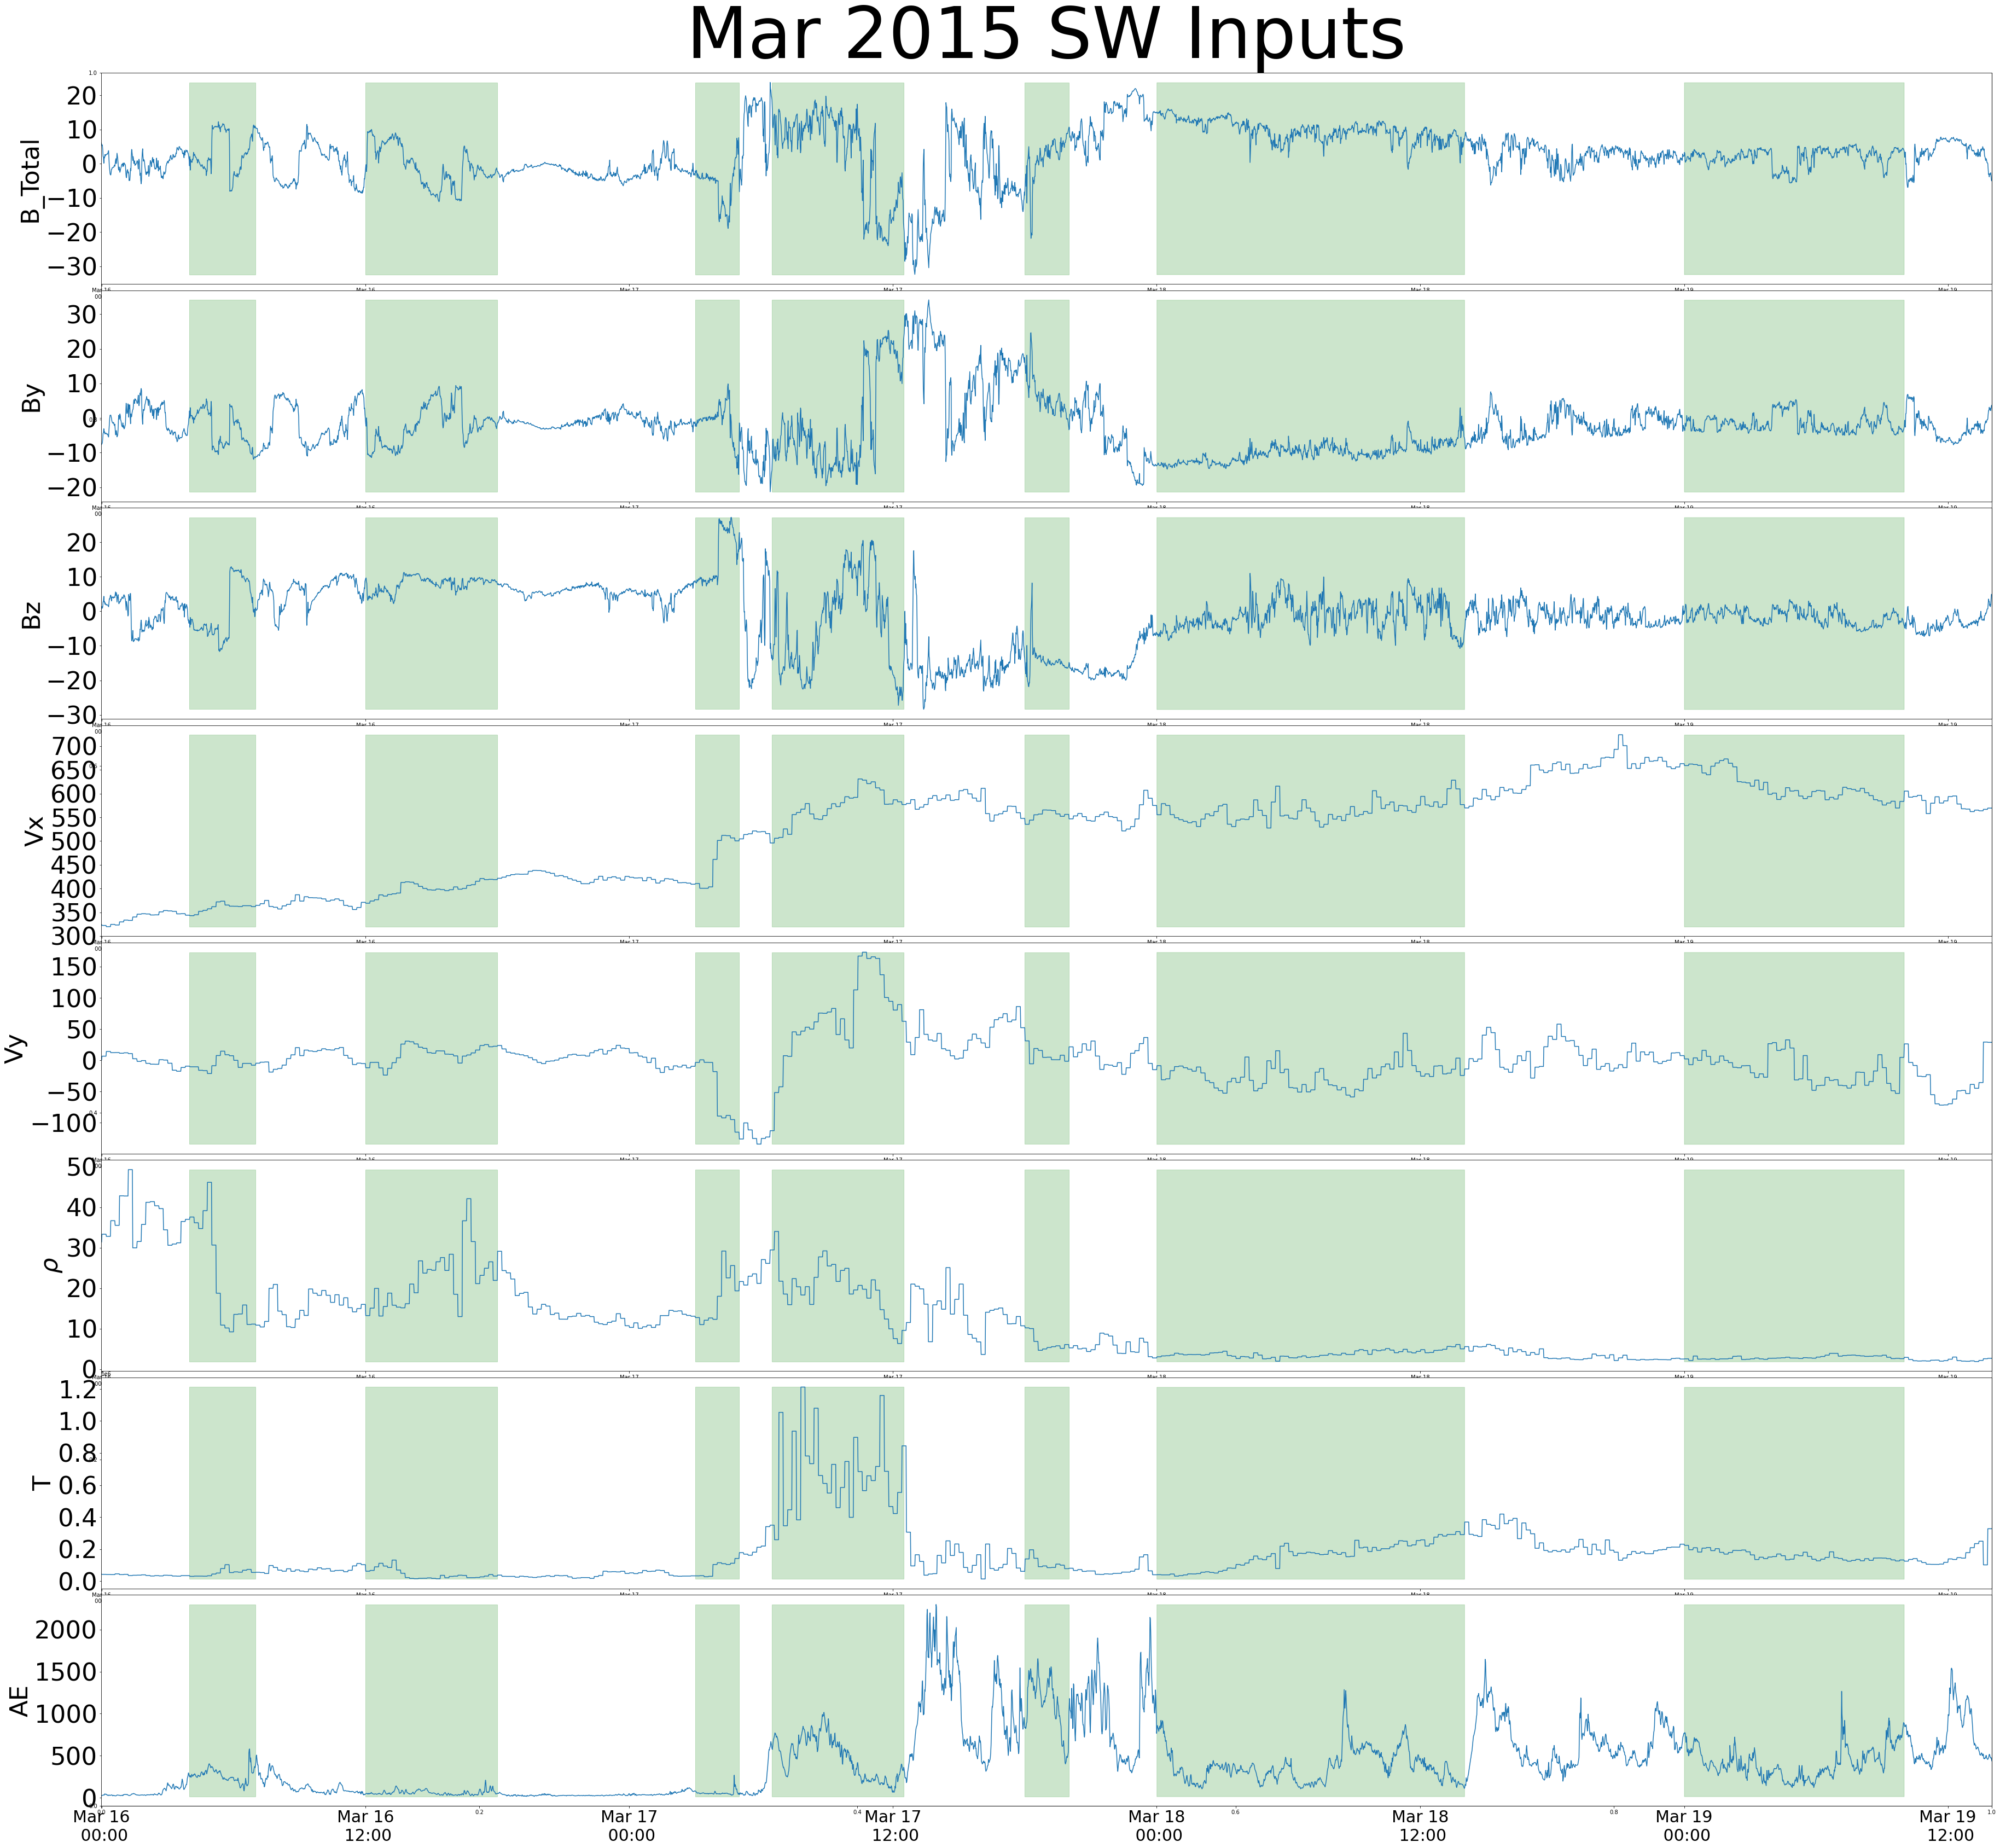

In [54]:
i=7

plot_model_SW_inputs(input_data, shading_dict['{0}'.format(i)]['stime'], shading_dict['{0}'.format(i)]['etime'], CONFIG['plot_titles'][i], CONFIG['test_storm_stime'][i], CONFIG['test_storm_etime'][i])
# plot_model_outputs(results_dict, i, shading_dict['{0}'.format(i)]['stime'], shading_dict['{0}'.format(i)]['etime'], CONFIG['splits'], CONFIG['plot_titles'][i], CONFIG['test_storm_stime'][i], CONFIG['test_storm_etime'][i])
# plot_model_dbht_inputs(input_data, shading_dict['{0}'.format(i)]['stime'], shading_dict['{0}'.format(i)]['etime'], CONFIG['plot_titles'][i], CONFIG['test_storm_stime'][i], CONFIG['test_storm_etime'][i])

In [11]:
def comparing_stations(results_dict, input_data, storm, stations, splits, title, stime, etime):
    
    maxes = []
    station0 = input_data[stations[0]][stime:etime]
    station1 = input_data[stations[1]][stime:etime]
    
    # calling the prep_k_fold function for each threshold. Should probably find a better way to do this.
    station0_results = prep_k_fold_results(results_dict[stations[0]]['storm_{0}'.format(storm)]['raw_results'], splits)
    station1_results = prep_k_fold_results(results_dict[stations[1]]['storm_{0}'.format(storm)]['raw_results'], splits)


    # this creats a new dataframe that will allow me to create a bar at the top of the plot to define the periods where the real, binary values have value 1.
    station0_bar = pd.DataFrame({'station0_bottom':station0_results['cross']*1.01,
                            'station0_top':station0_results['cross']*1.06},
                            index=station0_results.index)
    station1_bar = pd.DataFrame({'station1_bottom':station1_results['cross']*1.01,
                            'station1_top':station1_results['cross']*1.06},
                            index=station1_results.index)


    station0_bar.index=pd.to_datetime(station0_bar.index)					# adds datetime index
    station1_bar.index=pd.to_datetime(station1_bar.index)					# adds datetime index

    for station in stations:
        maxes.append(input_data[station][stime:etime]['dBHt'].max())
    
    fig = plt.figure(figsize=(60,55))				# establishing the larger plot
    plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, hspace=0.03)		# triming the whitespace in between the subplots
    plt.title('{0} Mag Inputs'.format(title), fontsize=130)

    ax1 = fig.add_subplot(411)			# initalizing the subplot
    a1 = ax1.plot(station0['dBHt'], label='dbdt')								# plots the mean columns of the dataframe.
    ax1.margins(x=0)							# tightning the plot margins
    ax1.set_ylim(0,np.max(maxes))
    ax1.set_ylabel(stations[0], fontsize='45')
    plt.yticks(fontsize='45')
    ax1.set_xticklabels('')
#     ax9 = ax1.twinx()
#     a9 = ax9.plot(station0['N'], color='red', label='N')								# plots the mean columns of the dataframe.
#     ax90 = ax9.plot(station0['E'], color='black', label='E')
    plt.yticks(fontsize='45')
    
#     lns = a1+a9+ax90
#     labs = [l.get_label() for l in lns]
#     ax1.legend(lns, labs, loc=0, fontsize=45)

    ax2 = fig.add_subplot(412, sharex=ax1, sharey=ax1)
    ax2.plot(station1['dBHt'])
    ax2.margins(x=0)
    ax2.set_ylabel(stations[1], fontsize='45')
    plt.yticks(fontsize='45')
    ax2.set_xticklabels('')
#     ax10 = ax2.twinx()
#     a10 = ax10.plot(station1['N'], color='red', label='N')								# plots the mean columns of the dataframe.
#     ax100 = ax10.plot(station1['E'], color='black', label='E')
    plt.yticks(fontsize='45')
    
    
    ax3 = fig.add_subplot(413, sharex=ax1)			# initalizing the subplot
    z1=np.array(station0_bar['station0_bottom'])		# creates an array from the y_bar dataframe
    z2=np.array(station0_bar['station0_top'])			# creates another array. These two arrays are compared to create the bar at the top of the plots.
    ax3.plot(station0_results['mean'])								# plots the mean columns of the dataframe.
    ax3.fill_between(station0_results.index, station0_results['bottom_perc'], station0_results['top_perc'], alpha=0.2)	# type: ignore # fills the area between the confidence interval with a lighter shade
    ax3.fill_between(station0_bar.index, station0_bar['station0_bottom'], station0_bar['station0_top'], where=z2>z1, alpha=1)												# type: ignore # creates a bar at the top of the plot indicating the positve part of the binary real data
    ax3.margins(x=0)							# tightning the plot margins
    ax3.set_ylabel(stations[0], fontsize='45')
    plt.yticks(fontsize='45')
    ax3.set_xticklabels('')

    ax4 = fig.add_subplot(414, sharex=ax1)
    z1=np.array(station1_bar['station1_bottom'])
    z2=np.array(station1_bar['station1_top'])
    ax4.plot(station1_results.index, station1_results['mean'])
    ax4.fill_between(station1_results.index, station1_results['bottom_perc'], station1_results['top_perc'], alpha=0.2)  # type: ignore
    ax4.fill_between(station1_bar.index, station1_bar['station1_bottom'], station1_bar['station1_top'], where=z2>z1, alpha=1)  # type: ignore
    ax4.margins(x=0)
    ax4.set_ylabel(stations[1], fontsize='45')
    plt.yticks(fontsize='45')
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n %H:%M'))			# adds the date to the bottom of

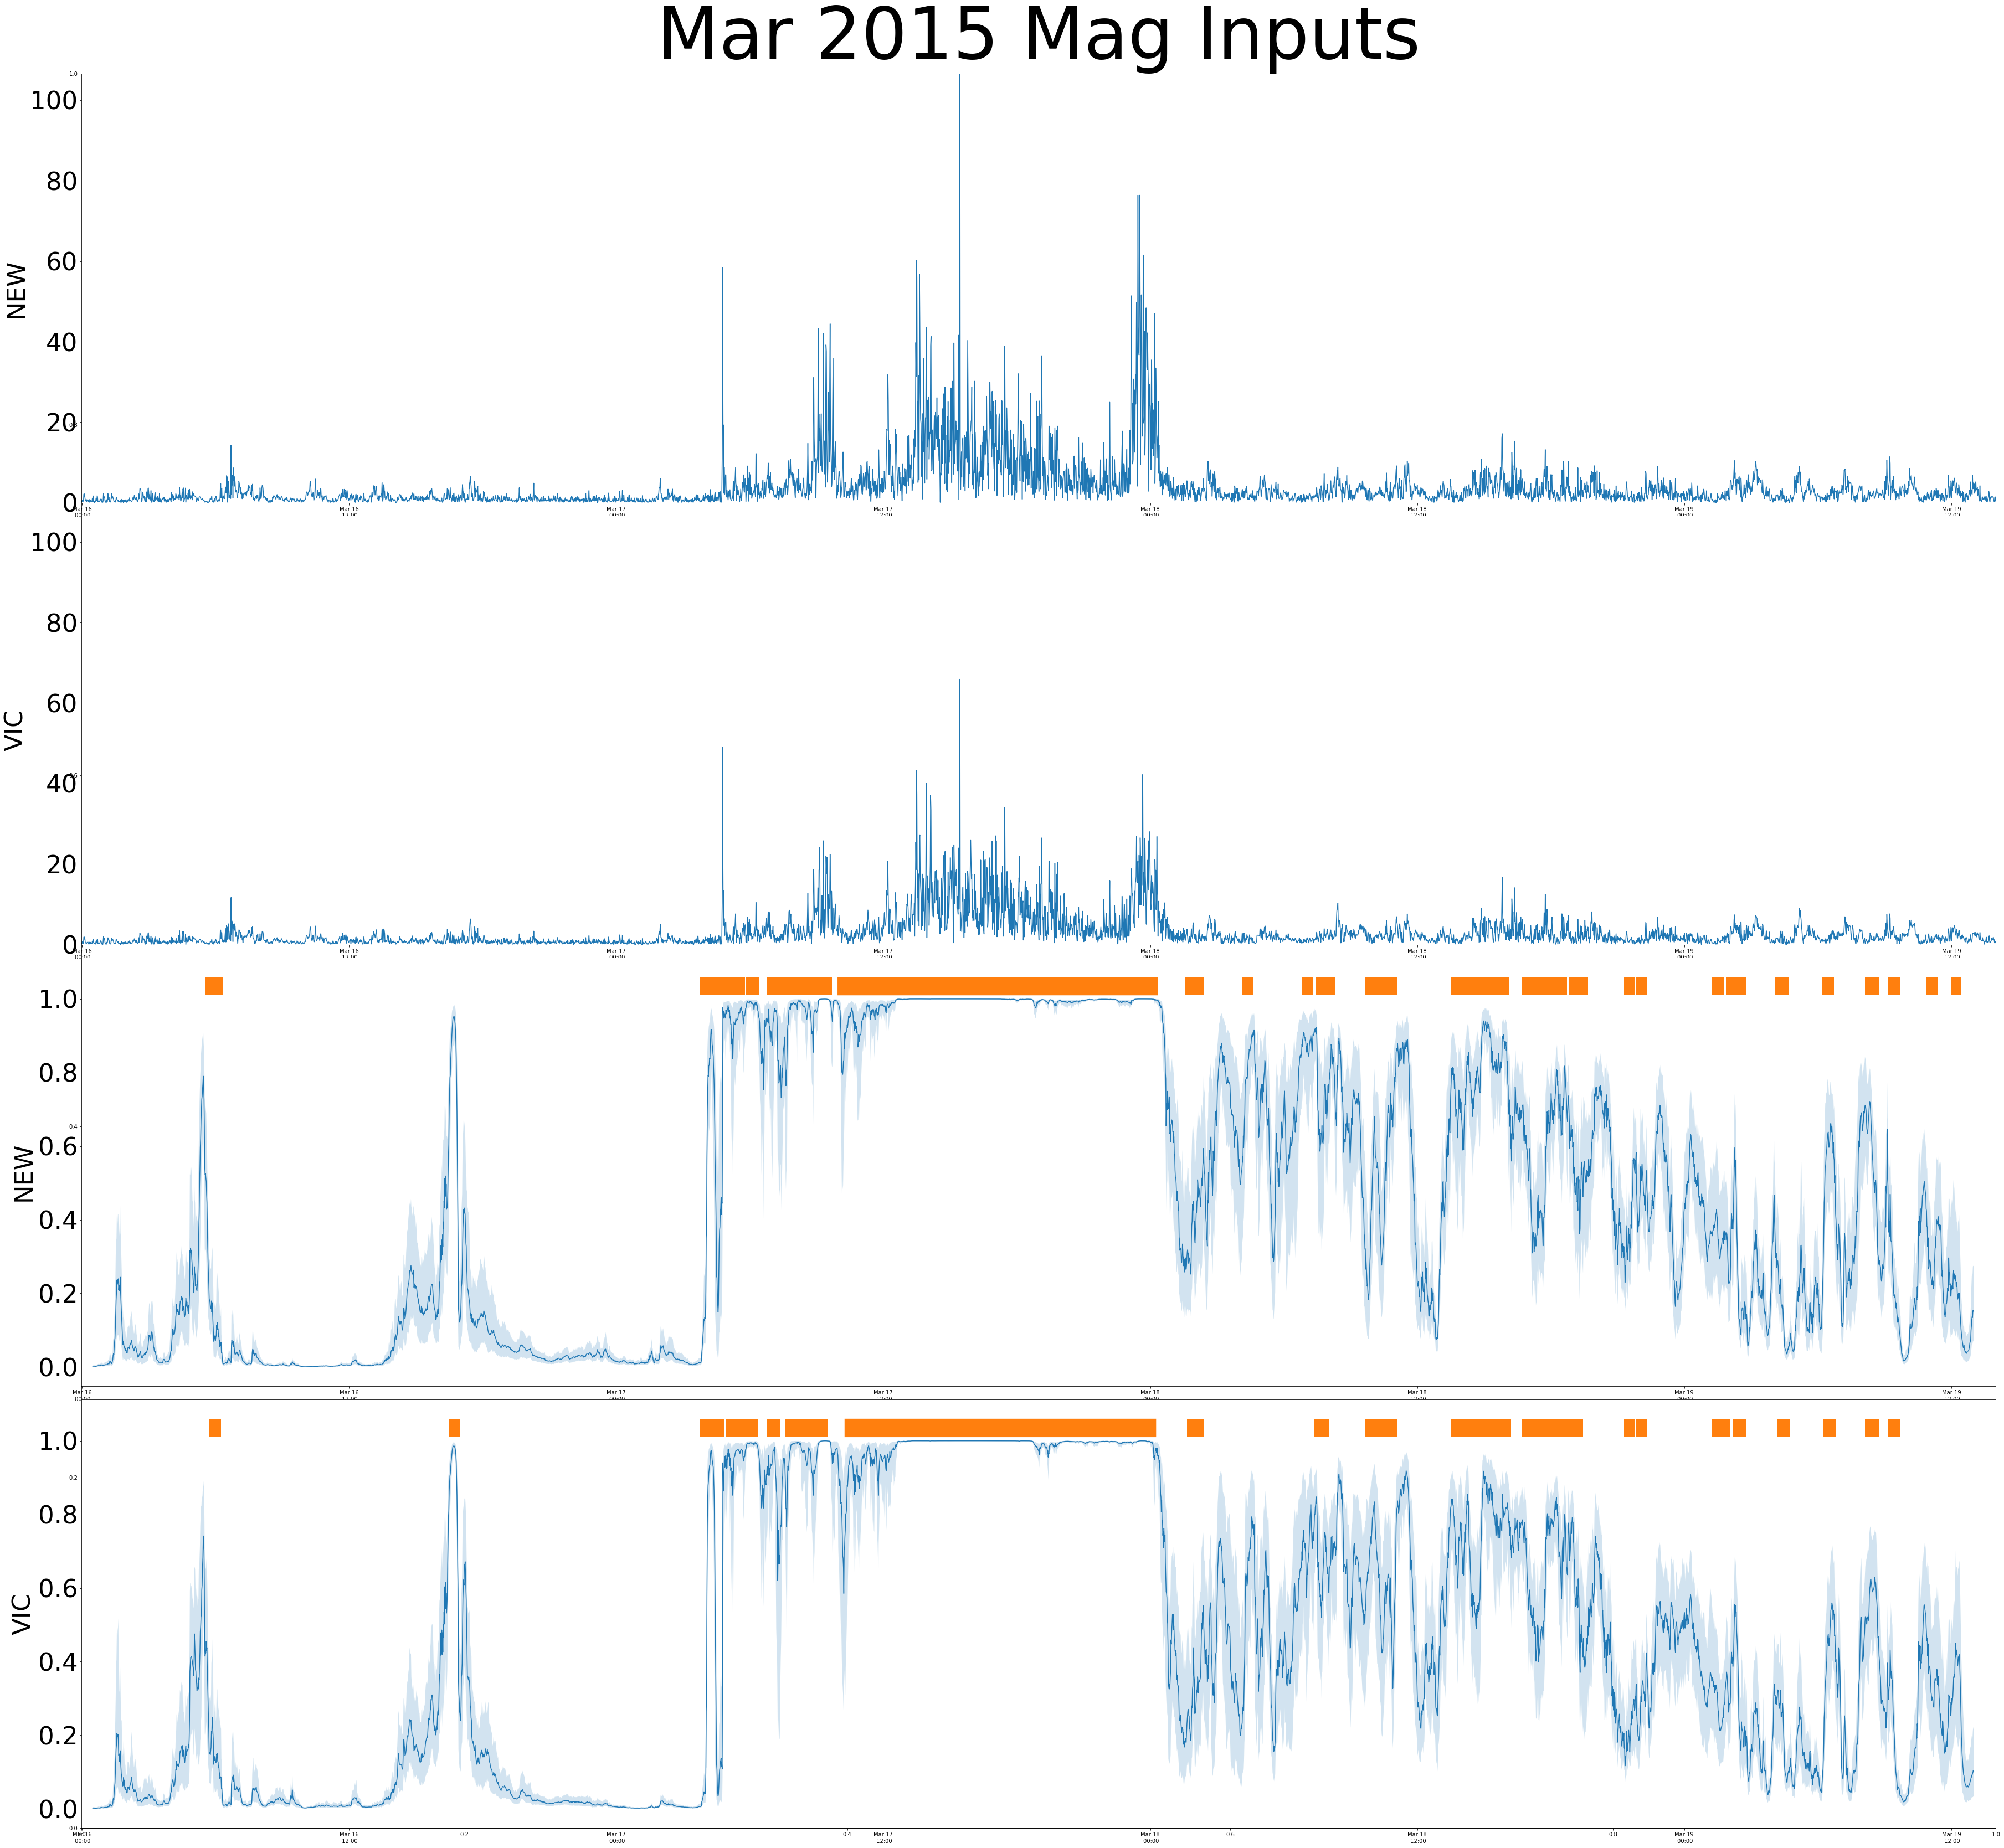

In [29]:
i=7
# stations=['BFE', 'WNG']
# stations=['ESK', 'LER']
# stations = ['OTT', 'STJ']
stations=['NEW', 'VIC']
comparing_stations(results_dict, input_data, i, stations, CONFIG['splits'], CONFIG['plot_titles'][i], CONFIG['test_storm_stime'][i], CONFIG['test_storm_etime'][i])